## New Data
This Jupiter Notebook is intended to guide the user in how to add data to MHDB and reproduce calculations using new and curated data.


We start by importing all python modules required to access MHDB and to perform our calculations. For this practice we want to access our `community` collection.

In [5]:
import os, sys
sys.path.insert(0, '../mhdb')

from pycalphad import Database, equilibrium, variables as v
from pymongo import MongoClient
from core import database, mongo
import matplotlib.pyplot as plt

client_string = os.getenv('MONGODB_URI')
client = MongoClient(client_string)

db = client['MHDB'] 
collections = [db['curated'], db['community']]


The `community` collection is open to anyone for depositing new tdbs. The data shared is available as phase models along with the references to the original assessments of the database. Run the cell bellow to investigate which contributions and metal hydrides are currently available in the community database.

In [64]:
entries = collections[1].find({})

references = []
for entry in entries:
    reference = entry['metadata']['parentDatabase']
    references.append(reference)

print(f'The MHDB-community currently has {len(set(references))} contributions.', '\n')

for i, reference in enumerate(set(references)):
    entries = collections[1].find({'metadata.parentDatabase': reference})

    systems = []
    for entry in entries:
        system = entry['material']['system']
        if 'H' in system.split('-') and len(system) != 1:
            systems.append(entry['material']['endmembers'])

    print(f'[{i+1}] The {reference} supports {len(set(systems))} hydride systems:')
    print(set(systems), '\n')

The MHDB-community currently has 1 contributions. 

[1] The `Replace with the title of the tdb.` | `Replace with the author(s) of the tdb.` | `Replace with the year or version of the tdb.` | `Replace with the DOI of the tdb or of a publication. If left blank, no reference is added to the database.` supports 10 hydride systems:
{'LANI5H1-X', 'NiH', 'LAHX', 'FCC', 'Ni2H', 'La0.076923Ni0.384615H0.538462', 'LaH', 'LaNi5H', 'La2H', 'La0.25H0.75'} 



### Defining your system

Now that we have access to all MHDB-community contributions we can define our system and run our calculations. We start by defining from which contribution we are retrieving our system's data and the hydride composition we are interested in. In this example, we are considering the `La-Ni-H_Ya_stringexported.tdb` contribution and the La2H hydride.

In [48]:
                                                         # INPUT(1): TDB reference and Chemical composition of metal hydride
tdb_reference = 'La-Ni-H_Ya.tdb'

chemical_composition = {'La': 1/3}

Once this is defined, we can load our system using data from MHDB `community` database.

In [65]:
elements = list(chemical_composition.keys()) + ['H', 'Va']
regex_pattern = '^(' + '|'.join(elements) + ')(-(' + '|'.join(elements) + '))*$'

data_collection = []
for collection in collections:
    data = collection.find({'$and': [{'material.system': {'$regex': regex_pattern, '$options': 'i'}}, {'metadata.parentDatabase': {'$regex': tdb_reference, '$options': 'i'}}]}, {'tdb': 1, '_id': 0})
    data_collection.extend(entry['tdb'] for entry in data)

try:
    data = database.many2one(elements, data_collection)
    data = database.one2tdb(data)

    dbf = Database(data)
    phases = list(dbf.phases.keys())
    print(f'Data for the following phases were successfully retrieved: {phases}')

except:
    print('No dataset found')

Data for the following phases were successfully retrieved: ['GAS', 'LIQUID', 'BCC', 'DHCP', 'FCC', 'LAHX']


Now, we’ll conduct an H2 decomposition temperature calculation as shown in the examples introduced in `TdH2.ipynb`. In the cell below, please specify the initial and final temperatures, the increment step for the temperature, and the pressure.

In [66]:
temperature_range = (300, 1800, 1)                                              # INPUT(2): Temperature range, and step increment
pressure = 101325                                                               # INPUT(3): Pressure

Set up our conditions, the commands below calculate the thermodynamic equilibrium and plot our results.

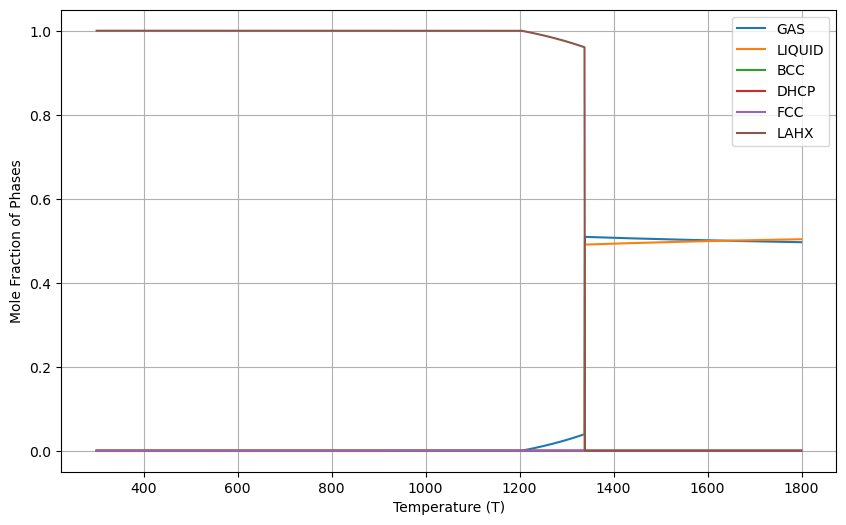

In [67]:
conditions = {v.N: 1, v.T: temperature_range, v.P: pressure}
conditions.update({v.X(element.upper()): fraction for element, fraction in chemical_composition.items()})

eq_result = equilibrium(dbf, elements, phases, conditions, output='HM')

plt.figure(figsize=(10, 6))

data = {}
for phase in phases:
    data[phase] = eq_result.NP.where(eq_result.Phase==phase).sel(P=101325).mean(dim='vertex').fillna(0)
    data[phase].plot(label=phase)

plt.title('')
plt.xlabel('Temperature (T)')
plt.ylabel('Mole Fraction of Phases')
plt.legend()
plt.grid(True)
plt.show()

### MHDB Contribute

Well done! Now you are all set to revisit the examples changing the reference data and/or changing each calculation's parameters.

Also, if you have your own tdb data, feel free to contribute to the open access MHDB-community database through our [MHDB Contribute](https://github.com/PhasesResearchLab/MHDB/issues/new?assignees=&labels=newTDB&projects=&template=mhdb-contribute.md&title=%5BMHDB+Contribute%5D) tool. 